# Task 1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below:

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  65792     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_1[0][0]']             
                                                                                            

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 10s 9ms/step - loss: 221.8685
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 137.9957
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 126.0392
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 120.7164
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 117.3001
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 114.5097
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 112.5365
Epoch 8/20
469/469 [==============================] - 3s 6ms/step - loss: 111.3154
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 110.2140
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 109.1297
Epoch 11/20
469/469 [==============================] - 2s 4ms/step - loss: 108.2569
Epoch 12/20
469/469 [==============================] - 2s 4ms/step - loss: 107.6628

## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test) # encoder predictions

313/313 [==============================] - 1s 2ms/step


In [13]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])
# decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 [==============================] - 0s 1ms/step


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

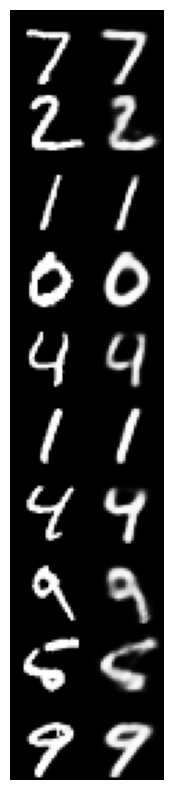

In [15]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [16]:
# use z_test_pred

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2)

In [19]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

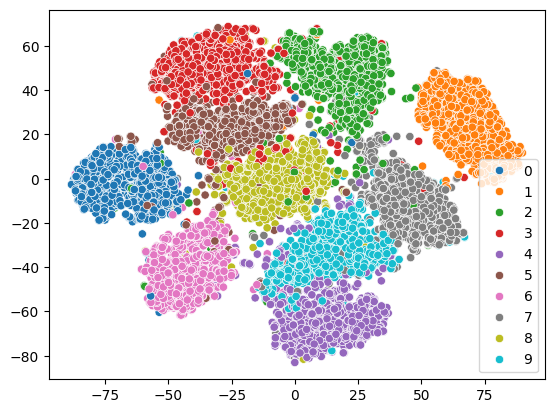

In [20]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

# h)

1/1 [==============================] - 0s 18ms/step


(-0.5, 27.5, 279.5, -0.5)

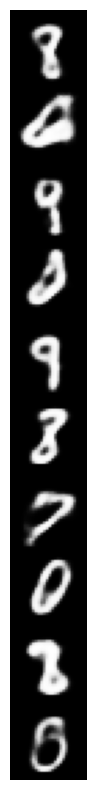

In [21]:
n = 10
z_sample = np.random.normal(size=(10, latent_dim))


x_decoded = vae.decoder.predict(z_sample)
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))

figure = np.zeros((digit_size * n, digit_size))
decoded = x_decoded

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')

Additional 2D interpolation grid

In [22]:
def generate_images_grid(images, rows, cols, digit_size):
    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            img = images[i][j].reshape(digit_size, digit_size)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

def interpolate_points(p1, p2, num_steps):
    ratios = np.linspace(0, 1, num_steps)
    return np.array([p1 + ratio * (p2 - p1) for ratio in ratios])

1/1 [==============================] - 0s 18ms/step


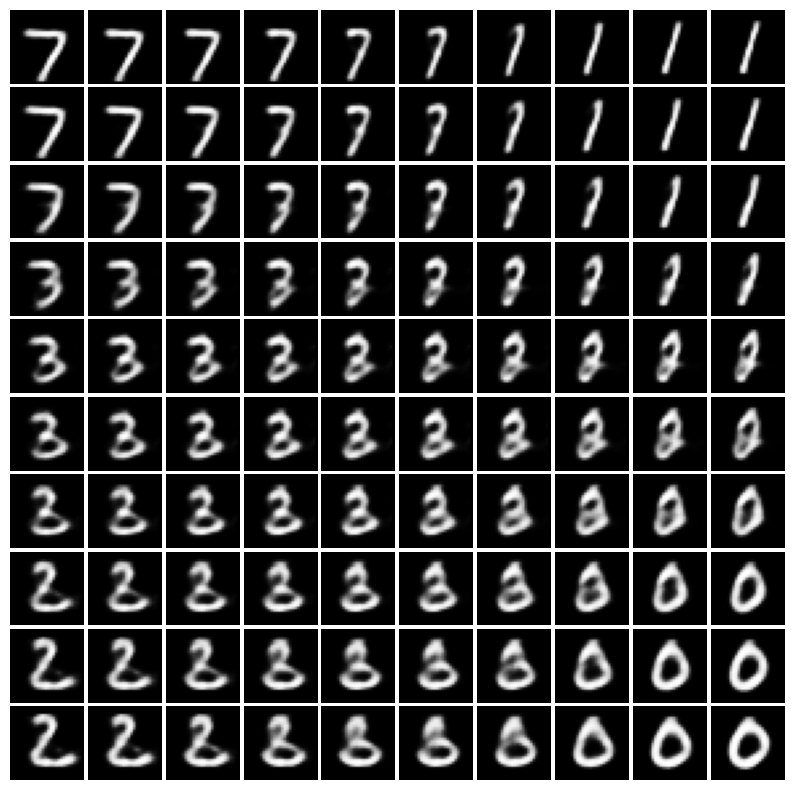

In [23]:
num_images = 10
random_points = z_test_pred[0][0:4, :]

left_vertical = interpolate_points(random_points[0], random_points[1], num_images)
right_vertical = interpolate_points(random_points[2], random_points[3], num_images)

# Generowanie liniowych przejść między punktami
interpolated_images = []

for i in range(num_images):
    v = interpolate_points(left_vertical[i], right_vertical[i], num_images)
    v = vae.decoder.predict(v)
    interpolated_images.append(v)

# Wyświetlenie siatki wygenerowanych obrazków
generate_images_grid(interpolated_images, num_images, num_images, digit_size)

# Task 2

In [24]:
y_train = y_train.astype('float32').reshape(-1, 1)
y_test = y_test.astype('float32').reshape(-1, 1)

In [25]:
encoder_inputs = keras.Input(shape=(original_dim,))
class_input = keras.Input(shape=(1,))

encoder_input_full = keras.layers.Concatenate()([encoder_inputs, class_input])
x = Dense(256, activation='relu')(encoder_input_full)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
cvae_encoder = keras.Model(encoder_input_full, [z_mean, z_log_var, z], name="encoder")
cvae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 785)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 256)                  201216    ['input_5[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 256)                  65792     ['dense_5[1][0]']             
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_6[1][0]']             
                                                                                            

In [26]:
latent_inputs = keras.Input(shape=(latent_dim,))
latent_class_input = keras.Input(shape=(1,))

decoder_input_full = keras.layers.Concatenate()([latent_inputs, latent_class_input])
x = Dense(256, activation='relu')(decoder_input_full)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
cvae_decoder = keras.Model(decoder_input_full, decoder_outputs, name="decoder")
cvae_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_7 (Dense)             (None, 256)               3072      
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270352 (1.03 MB)
Trainable params: 270352 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        x_train, y_train = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(
                tf.concat((x_train, y_train), 1)
            )
            c = y_train
            z_c = tf.concat([z, c], 1)

            reconstruction = self.decoder(z_c)
            total_loss = -elbo_vae(x_train, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [28]:
cvae = cVAE(cvae_encoder, cvae_decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(x_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 5s 6ms/step - loss: 218.3090
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 138.5323
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 126.6293
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 120.4505
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 117.2790
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 114.8308
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 112.8617
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 111.2594
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 109.7999
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 108.7471
Epoch 11/20
469/469 [==============================] - 3s 5ms/step - loss: 107.6793
Epoch 12/20
469/469 [==============================] - 3s 7ms/step - loss: 106.8421
E

# f)

In [29]:
z_test_pred = cvae.encoder.predict(
    np.concatenate((x_test, y_test), axis=1)
)

313/313 [==============================] - 1s 2ms/step


In [30]:
test_pred = cvae.decoder.predict(
    np.concatenate((z_test_pred[2], y_test), axis=1)
)

313/313 [==============================] - 0s 1ms/step


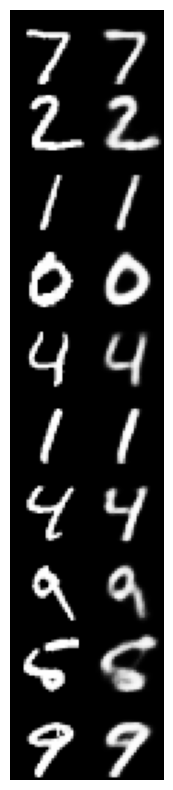

In [31]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# g)

In [32]:
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

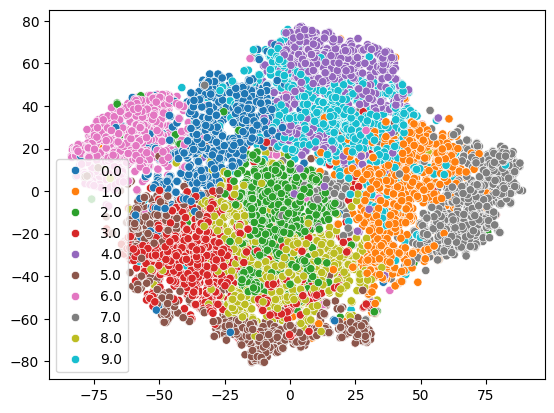

In [33]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test.reshape(1, -1)[0][:N], palette=sns.color_palette("tab10"))
plt.show()

# h)

1/1 [==============================] - 0s 17ms/step


(-0.5, 27.5, 279.5, -0.5)

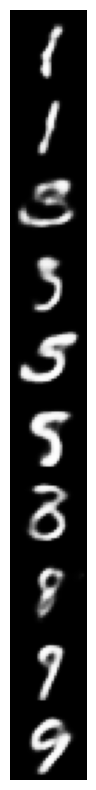

In [34]:
n = 10
z_sample = np.random.normal(size=(10, latent_dim))
y_class = np.arange(10).astype('float32').reshape(-1, 1)


x_decoded = cvae.decoder.predict(np.concatenate((z_sample, y_class), axis=1))
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))

figure = np.zeros((digit_size * n, digit_size))
decoded = x_decoded

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')

Additional 2D interpolation grid

1/1 [==============================] - 0s 20ms/step


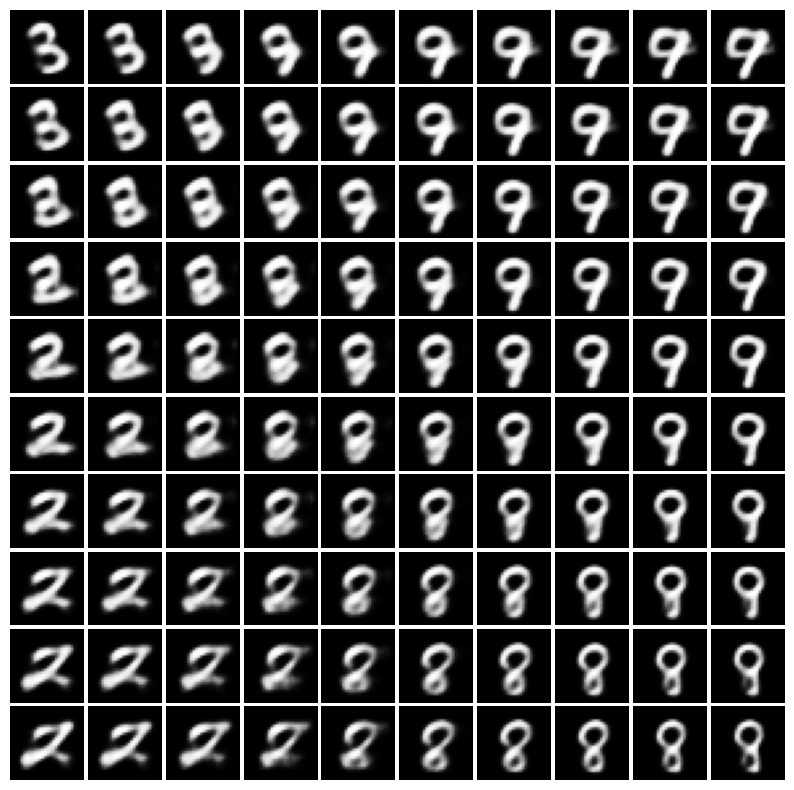

In [35]:
num_images = 10

z_sample = np.random.normal(size=(4, latent_dim))
y_class = np.array([2, 3, 8, 9]).astype('float32').reshape(-1, 1)
random_points = [
    np.concatenate((z_sample[i], y_class[i]), axis=0)
    for i in range(len(y_class))
]

left_vertical = interpolate_points(random_points[0], random_points[1], num_images)
right_vertical = interpolate_points(random_points[2], random_points[3], num_images)

# Generowanie liniowych przejść między punktami
interpolated_images = []

for i in range(num_images):
    v = interpolate_points(left_vertical[i], right_vertical[i], num_images)
    v = cvae.decoder.predict(v)
    interpolated_images.append(v)

# Wyświetlenie siatki wygenerowanych obrazków
generate_images_grid(interpolated_images, num_images, num_images, digit_size)